# PERSONALIZED PRODUCT RECOMMENDATIONS MODEL FOR FLIPKART GRID 5.0 
According to given problem statement We have to  develop a model or system that recommends products based on user preferences, histories, and similarity between users. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
from sklearn.decomposition import TruncatedSVD

# Import dataset 
We are using a dataset that contains information about fashion products. 


In [3]:
data = pd.read_csv('product_data.csv')

In [4]:
data.head()

,UserId,ProductId,Rating,subCategory,articleType,baseColour,Timestamp,productDisplayName,Unnamed: 8
0,A39HTATAQ9V7YF,205616461,5,Topwear,Shirts,Navy Blue,1369699200,Turtle Check Men Navy Blue Shirt,NaN
1,A3JM6GV9MNOF9X,558925278,3,Bottomwear,Jeans,Blue,1355443200,Peter England Men Party Blue Jeans,NaN
2,A1Z513UWSAAO0F,558925278,5,Watches,Watches,Silver,1404691200,Titan Women Silver Watch,NaN
3,A1WMRR494NWEWV,733001998,4,Bottomwear,Track Pants,Black,1382572800,Manchester United Men Solid Black Track Pants,NaN
4,A3IAAVS479H7M7,737104473,1,Topwear,Tshirts,Grey,1274227200,Puma Men Grey T-shirt,NaN


# Data Cleaning 
In order to improve accuracy, data must first be cleaned. Next, missing data in the dataset must be handled. 

In [5]:
data.columns

Index(['UserId', 'ProductId', 'Rating', 'subCategory', 'articleType',
       'baseColour', 'Timestamp', 'productDisplayName', 'Unnamed: 8'],
      dtype='object')

In [6]:
data = data[['UserId', 'ProductId', 'Rating', 'subCategory', 'articleType',
       'baseColour', 'productDisplayName']]


In [7]:
data.isnull().sum()

UserId                0
ProductId             0
Rating                0
subCategory           0
articleType           0
baseColour            8
productDisplayName    3
dtype: int64

In [8]:
missing_data = pd.DataFrame(data.isnull().mean()*100)
missing_data

,0
UserId,0.000000
ProductId,0.000000
Rating,0.000000
subCategory,0.000000
articleType,0.000000
baseColour,0.040002
productDisplayName,0.015001


In [9]:
column_to_check = 'productDisplayName'  # Replace with the actual column name
data_without_missing = data.dropna(subset=[column_to_check], inplace=True)


In [10]:
missing_data = pd.DataFrame(data.isnull().mean()*100)
missing_data

,0
UserId,0.000000
ProductId,0.000000
Rating,0.000000
subCategory,0.000000
articleType,0.000000
baseColour,0.030006
productDisplayName,0.000000


In [11]:
data.shape

(19996, 7)

# Exploratory Data Analysis

In [12]:
Q1 = np.percentile(data['Rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data['Rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1


# Above Upper bound
upper = data['Rating'] >= (Q3+1.5*IQR)
 
print("Upper bound:",upper)
print(np.where(upper))
 
# Below Lower bound
lower = data['Rating'] <= (Q1-1.5*IQR)
print("Lower bound:", lower)
print(np.where(lower))

Upper bound: 0        False
1        False
2        False
3        False
4        False
         ...  
19994    False
19995    False
19996    False
19997    False
19998    False
Name: Rating, Length: 19996, dtype: bool
(array([], dtype=int64),)
Lower bound: 0        False
1        False
2        False
3        False
4         True
         ...  
19994    False
19995    False
19996    False
19997    False
19998     True
Name: Rating, Length: 19996, dtype: bool
(array([    4,    23,    30, ..., 19977, 19985, 19995], dtype=int64),)


C:\Users\rahul\AppData\Local\Temp\ipykernel_10212\1517567348.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data['Rating'], 25,
C:\Users\rahul\AppData\Local\Temp\ipykernel_10212\1517567348.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data['Rating'], 75,


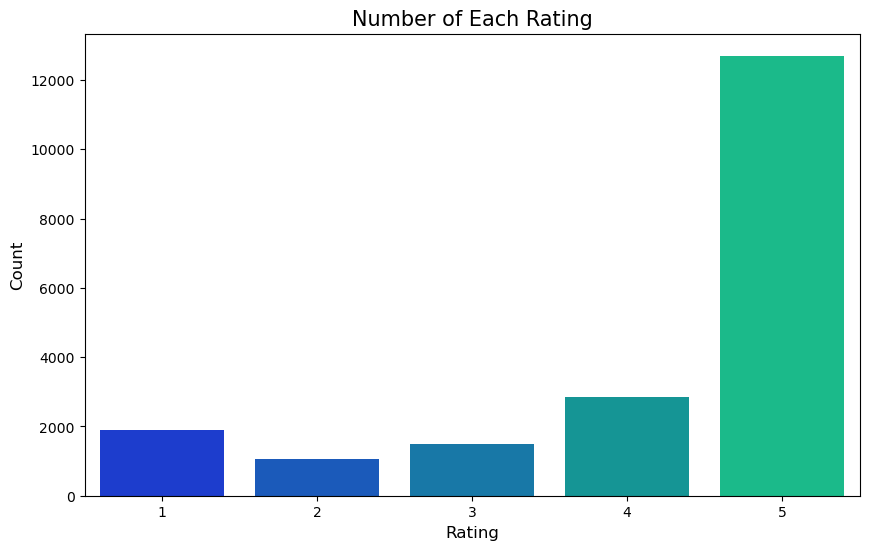

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=data, palette='winter')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Each Rating', fontsize=15)
plt.show()

In [14]:
df_rating=pd.DataFrame({'Number of Rating':data.groupby('ProductId').count()['Rating'], 'Mean Rating':data.groupby('ProductId').mean()['Rating']})

C:\Users\rahul\AppData\Local\Temp\ipykernel_10212\3559885644.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rating=pd.DataFrame({'Number of Rating':data.groupby('ProductId').count()['Rating'], 'Mean Rating':data.groupby('ProductId').mean()['Rating']})


In [15]:
df_rating.head()

,Number of Rating,Mean Rating
ProductId,,
1304139212,1,5.000000
1304139220,1,5.000000
130414089X,1,5.000000
130414643X,3,4.333333
1304146537,1,5.000000


# Top products based on sales

In [16]:


# Group by 'ProductId' and count the number of ratings for each product
popular_products = pd.DataFrame(data.groupby('ProductId')['Rating'].count())
popular_products.columns = ['NumRatings']  # Rename the column

# Sort products by the number of ratings in descending order
most_popular = popular_products.sort_values('NumRatings', ascending=False)

# Get the top 10 most popular products
top_10_most_popular = most_popular.head(10)

# Merge with the original dataset to get additional information
top_10_most_popular = top_10_most_popular.merge(data[['ProductId', 'subCategory', 'articleType']], on='ProductId', how='left')

# Drop duplicates to ensure each product appears only once
top_10_most_popular = top_10_most_popular.drop_duplicates(subset=['ProductId'])

print(top_10_most_popular)



       ProductId  NumRatings subCategory          articleType
0     B0000530ED         584     Watches              Watches
584   B00004TUBL         558       Shoes         Casual Shoes
1142  B0000536P4         442        Bags             Handbags
1584  B00005A9WP         430     Topwear              Tshirts
2014  B000052YM7         412  Bottomwear                Jeans
2426  B000050B6U         376     Topwear               Kurtas
2802  B000052YP6         341     Topwear              Tshirts
3143  B00005A43X         315   Jewellery  Necklace and Chains
3458  B000052YMR         313       Shoes         Sports Shoes
3771  B000052XZP         288        Lips             Lipstick


<Axes: xlabel='ProductId'>

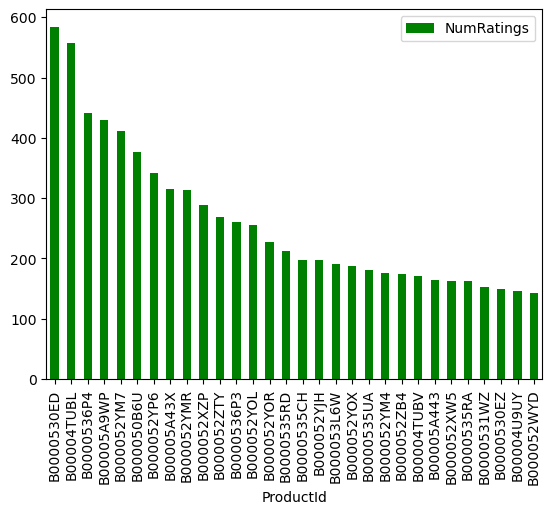

In [17]:
most_popular.head(30).plot(kind = "bar", color='g')

In [18]:
print('Number of unique users', len(data['UserId'].unique()))

Number of unique users 19098


In [19]:
max_ratings1 = data[data['Rating'] >= 4.0]
print('Number of unique products rated high',len(max_ratings1['ProductId'].unique()))

Number of unique products rated high 1267


# Model Preparation
Now we prepare a model and train it by train_data and generate output by test_data

In [20]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.2, random_state=0)

In [21]:
train_data.head()

,UserId,ProductId,Rating,subCategory,articleType,baseColour,productDisplayName
6489,A2QPJWFX3XT6N7,B000052YJX,5,Topwear,Kurtas,Green,Vishudh Women Printed Green Kurta
12054,A45P4XG65VISY,B0000530ED,5,Shoes,Flats,Green,Senorita Women Green Sandals
6279,A1DDOISWL7HABL,B000052YJM,5,Topwear,Sweatshirts,Red,ADIDAS Originals Women Trefoil Hoodie Red Swea...
11716,A1VR3AUXR1950S,B0000530ED,5,Topwear,Shirts,White,Basics MenNavy Slim Fit Checked Shirt
8745,A1QZJH9IKOAS9D,B000052YOL,1,Topwear,Kurtas,Orange,Aurelia Women Printed Orange Kurta


In [22]:
train_data.shape

(15996, 7)

In [23]:
test_data.head()

,UserId,ProductId,Rating,subCategory,articleType,baseColour,productDisplayName
5156,AFQZT1RQVEOOX,B000052XZP,5,Fragrance,Deodorant,Blue,F5 Women Pack of 3 Deos
16314,A2QGGSHJQDA3QX,B0000536EW,5,Loungewear and Nightwear,Lounge Pants,Grey,Puma Men Steel Grey 3/4 Length Pants
18620,A2JBW35LB6UFCQ,B00005A43X,4,Topwear,Shirts,Brown,John Miller Men Solid Brown Shirts
2420,A2UIXU97JYCPZG,B000026BTH,5,Bags,Backpacks,Blue,Nike Unisex Brasilia 5 Me Blue Backpacks
8771,A3BVXMNBZ4RQBZ,B000052YOL,5,Shoes,Sports Shoes,White,Lotto Men White Sports Shoes


In [24]:
top_products = train_data.groupby('ProductId').agg({
    'Rating': 'count',         # Count the occurrences of Rating
    'subCategory': 'first',    # Take the first value of subCategory
    'articleType': 'first'     # Take the first value of articleType
}).sort_values(by='Rating', ascending=False).head(15)

print(top_products)


            Rating subCategory      articleType
ProductId                                      
B0000530ED     473       Shoes            Flats
B00004TUBL     464   Innerwear  Innerwear Vests
B0000536P4     342       Shoes     Sports Shoes
B00005A9WP     330     Topwear           Kurtas
B000052YM7     321        Bags         Handbags
B000050B6U     308       Shoes     Casual Shoes
B000052YP6     282       Shoes     Casual Shoes
B000052YMR     250  Flip Flops       Flip Flops
B00005A43X     246     Topwear          Tshirts
B000052XZP     233     Topwear           Kurtas
B0000536P3     212     Eyewear       Sunglasses
B000052ZTY     205     Topwear           Kurtas
B000052YOL     197     Topwear           Kurtas
B000052YOR     175    Headwear             Caps
B0000535RD     171  Flip Flops       Flip Flops


In [25]:
train_data_sort = train_data.sort_values(
    ['Rating', 'ProductId', 'subCategory', 'articleType'],
    ascending=[False, False, False, False])


In [26]:

train_data_sort.head()

,UserId,ProductId,Rating,subCategory,articleType,baseColour,productDisplayName
19995,A11S57T1PZJUUI,B00005CDS9,5,Topwear,Tshirts,Green,ADIDAS Men's Dare Green T-shirt
19996,A3L4X1NXBBYPPU,B00005CDS9,5,Shoes,Sports Shoes,Black,Nike Women Flex 2012 RN Black Sports Shoes
19992,A8DM2HFTYQHWV,B00005CDS9,5,Shoes,Casual Shoes,Black,Skechers Women Black Shoes
19989,A3A2SOU9HIAMOF,B00005CDS9,5,Sandal,Sandals,Brown,Coolers Men Brown Sandals
19993,A28X7NZ02016FO,B00005CDS9,5,Loungewear and Nightwear,Nightdress,Off White,Red Rose Women Off White Nightdress


# Model 1: Popularity based recommender model
The implementation of Popularity-Based Filtering is straighforward. All we have to do is sort our products based on ratings, and display the top products of our list. Therefore, we should;

Create a metric to score or rate the products.
Calculate the score for every product.
Sort the scores and recommend the best rated product to the users.
We can use the average ratings of the products as the score but using this will not be fair enough since a product with 5average rating and only43 votes cannot be considered better than the product with 4 as average rating but 40 votes. So, we use IMDB's weighted rating formula to score the products, as follows:

Weighted Rating (WR) = ((v/(v+m))*R)+((m/(v+m))*C)
 
 

v: the number of votes for the product

m: the minimum votes required to be listed in the chart

R: the average rating of the product

C: the mean vote across the whole report

In [27]:
df_rating['Mean Rating'].mean()

4.172811891038318

In [28]:
df_rating['Number of Rating'].quantile(q=0.9)

29.0

# 
Calculating Product score and filtering tham based on score 

In [29]:
def product_score(x):
    v=x['Number of Rating']
    m=df_rating['Number of Rating'].quantile(q=0.9)
    R=x['Mean Rating']
    C=df_rating['Mean Rating'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [30]:
df_rating['score']=df_rating.apply(product_score, axis=1)

In [31]:
df_filtered=df_rating['score']

In [32]:
df_filtered.head()

ProductId
1304139212    4.200385
1304139220    4.200385
130414089X    4.200385
130414643X    4.187861
1304146537    4.200385
Name: score, dtype: float64

# 
Finally, we sort the dataframe based on the score feature, and we output the the top 10 popular products.

In [33]:
df_highscore = df_filtered.sort_values(ascending=False).head(10)


In [34]:
df_highscore

ProductId
B000052YMR    4.660852
B000052YN6    4.644573
B000052YJH    4.634412
B00004U9UY    4.634352
B00005323F    4.631700
B000052YN7    4.625111
B00004U9V2    4.619930
B00004TUBL    4.611604
B0000536EK    4.606390
B000052YP6    4.605437
Name: score, dtype: float64

In [35]:
df_filtered=df_rating[df_rating['Number of Rating']>df_rating['Number of Rating'].quantile(q=0.9)]

In [36]:
df_filtered.shape

(139, 3)

In [37]:
df_highscore

ProductId
B000052YMR    4.660852
B000052YN6    4.644573
B000052YJH    4.634412
B00004U9UY    4.634352
B00005323F    4.631700
B000052YN7    4.625111
B00004U9V2    4.619930
B00004TUBL    4.611604
B0000536EK    4.606390
B000052YP6    4.605437
Name: score, dtype: float64

# Here are the Top N product of website based on popularity 

In [38]:


# Reset the index of df_highscore if the product IDs are currently the index
df_highscore_reset = df_highscore.reset_index()

# Merge the two DataFrames using the 'ProductId' column
merged_df = df_highscore_reset.merge(data[['ProductId', 'subCategory', 'articleType']], on='ProductId', how='left')

# Take user input for the number of top products to show
no_of_total_product = int(input("Enter the number of top products: "))

# Set the 'ProductId' column as the index again
merged_df = merged_df.set_index('ProductId')

# Get the top N products
top_n_merged_df = merged_df.head(no_of_total_product)

print(top_n_merged_df)


Enter the number of top products: 10
               score subCategory            articleType
ProductId                                              
B000052YMR  4.660852       Shoes           Sports Shoes
B000052YMR  4.660852     Watches                Watches
B000052YMR  4.660852  Bottomwear               Leggings
B000052YMR  4.660852     Topwear                 Kurtas
B000052YMR  4.660852     Topwear                Tshirts
B000052YMR  4.660852   Fragrance  Perfume and Body Mist
B000052YMR  4.660852     Topwear                 Shirts
B000052YMR  4.660852     Topwear                 Kurtis
B000052YMR  4.660852      Sandal                Sandals
B000052YMR  4.660852     Topwear                   Tops


Remember that regardless of the user's preferences, this popularity-based recommender offers a broad chart of suggested products to all users. It does not make tailored recommendations based on users' preferences or interests, and it is not responsive to the preferences and interests of a specific user.


# Recommendation System - Part II
Model-based collaborative filtering system
Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.

A model based collaborative filtering technique is closen here as it helps in making predicting products for a particular user by identifying patterns based on preferences from multiple user data.using Singular Value Decomposition (SVD)





In [39]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import joblib
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19996 entries, 0 to 19998
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   UserId              19996 non-null  object
 1   ProductId           19996 non-null  object
 2   Rating              19996 non-null  int64 
 3   subCategory         19996 non-null  object
 4   articleType         19996 non-null  object
 5   baseColour          19990 non-null  object
 6   productDisplayName  19996 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


In [41]:
data.isnull().sum()

UserId                0
ProductId             0
Rating                0
subCategory           0
articleType           0
baseColour            6
productDisplayName    0
dtype: int64

In [42]:
data.fillna(data.mean,inplace=True)

In [43]:
data.isnull().sum()

UserId                0
ProductId             0
Rating                0
subCategory           0
articleType           0
baseColour            0
productDisplayName    0
dtype: int64

In [44]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', data['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', data['ProductId'].nunique())

Number of unique users in Raw data =  19098
Number of unique product in Raw data =  1398


In [45]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = data.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.head()

ProductId,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,...,B00005BJ8X,B00005BJ91,B00005BL1R,B00005BLRH,B00005BWXD,B00005CDRP,B00005CDRY,B00005CDS5,B00005CDS7,B00005CDS9
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A020135981U0UNEAE4JV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A024581134CV80ZBLIZTZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (19098, 1398)


In [47]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,...,B00005BJ91,B00005BL1R,B00005BLRH,B00005BWXD,B00005CDRP,B00005CDRY,B00005CDS5,B00005CDS7,B00005CDS9,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A020135981U0UNEAE4JV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A024581134CV80ZBLIZTZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [48]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

ProductId,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,...,B00005BJ8X,B00005BJ91,B00005BL1R,B00005BLRH,B00005BWXD,B00005CDRP,B00005CDRY,B00005CDS5,B00005CDS7,B00005CDS9
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Singular Value Decomposition(SVD)


In [49]:
# Convert pivot_df to CSR format
pivot_df_csr = scipy.sparse.csr_matrix(pivot_df)

# Perform Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_csr, k=10)


In [50]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.00000000e+00  9.00819539e-19  4.87890978e-19 ... -2.71050543e-19
   6.26804381e-20  6.77626358e-20]
 [ 1.63645950e-06 -2.14115827e-08  1.60129639e-05 ...  9.47328543e-07
  -1.59462702e-07 -1.23148248e-09]
 [ 3.09782143e-07 -7.10211677e-08 -1.46991546e-04 ...  2.62582303e-05
  -1.35499118e-06 -1.37994448e-07]
 ...
 [ 1.82811578e-05  5.26718492e-10  2.31424048e-07 ...  6.83208996e-08
   1.84553851e-10 -5.12467730e-04]
 [-9.46108252e-05  1.41064271e-07  1.03376481e-05 ...  2.19677925e-02
  -1.28646658e-06 -4.09724462e-07]
 [ 1.15010668e-04 -9.21753132e-06 -8.34642537e-06 ...  4.70323945e-04
  -4.53159598e-07 -5.37827732e-05]]


In [51]:

print('Sigma: \n',sigma)

Sigma: 
 [ 72.83574206  74.64508389  84.41787224  84.95344472  85.11370566
  87.09073573  88.3889385   89.17796134  94.47939493 111.31593034]


In [52]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 72.83574206   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          74.64508389   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          84.41787224   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          84.95344472   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          85.11370566
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   87.09073573   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          88.3889385    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [53]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 0.00000000e+00 -5.50633853e-17 -6.95243328e-18 ...  5.60002753e-17
   2.78060164e-18  5.80893862e-17]
 [ 2.32205612e-17 -1.49987210e-32  1.67841790e-17 ... -9.54467588e-18
   3.23227147e-17  4.79269862e-17]
 [-1.62630326e-19  1.92602057e-18  3.13238257e-31 ...  3.59319560e-17
  -1.32530122e-17 -9.00140721e-17]
 ...
 [ 9.10729825e-18 -2.06692980e-17 -5.42101086e-19 ... -2.56678056e-18
  -1.72733332e-17 -4.72104514e-17]
 [-8.62279540e-18  1.81438163e-17 -1.04083409e-17 ... -2.27081461e-17
  -2.07662022e-17  1.97666902e-17]
 [ 1.68178392e-17 -3.40252076e-17  1.50178942e-17 ...  3.27388560e-17
   3.77800666e-17 -1.65114608e-17]]


In [54]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,...,B00005BJ8X,B00005BJ91,B00005BL1R,B00005BLRH,B00005BWXD,B00005CDRP,B00005CDRY,B00005CDS5,B00005CDS7,B00005CDS9
0,3.233634e-33,-3.530751e-33,2.305200e-33,-2.342007e-33,1.162882e-34,7.354443e-33,-6.517520e-33,-6.257537e-33,-7.277751e-33,2.158023e-33,...,8.144253e-34,2.933003e-33,-6.781904e-23,7.352911e-24,-1.467195e-22,-2.969733e-33,-1.481816e-23,-3.194504e-34,3.000490e-33,1.360571e-33
1,4.083391e-20,-1.027974e-19,-1.353904e-20,1.253254e-20,6.662729e-20,1.454235e-19,-5.090602e-20,-4.781004e-20,-9.918504e-20,3.467469e-20,...,5.679851e-21,2.546876e-20,3.204049e-09,3.658990e-10,7.553598e-10,-4.021855e-20,8.410788e-12,1.370274e-19,4.678890e-21,8.593465e-20
2,1.663272e-19,-4.392008e-19,3.760465e-20,-1.217940e-19,1.213250e-19,4.739600e-19,-2.363547e-19,-5.092048e-19,-4.567250e-19,1.422700e-19,...,6.007156e-20,2.032117e-19,7.183413e-08,1.920767e-08,2.301105e-09,-1.897459e-19,3.714550e-09,-1.216650e-18,7.617129e-21,2.468727e-18
3,1.496880e-22,-3.698159e-21,-3.874267e-22,4.513690e-22,2.800500e-21,3.947807e-21,-1.951690e-21,9.795813e-22,-4.352082e-21,1.151068e-21,...,-1.163360e-22,-4.123294e-22,5.923132e-10,1.684895e-11,1.932988e-10,-5.786153e-22,4.624619e-12,2.140643e-21,2.380268e-22,6.074259e-21
4,-3.635926e-33,2.667633e-33,-2.829919e-33,3.759288e-33,3.777292e-34,-8.209735e-33,7.929480e-33,9.811656e-33,5.579572e-33,-1.306212e-33,...,-1.314290e-33,-4.685616e-33,4.118502e-23,-5.619785e-23,-1.437290e-22,3.627289e-33,-8.851359e-24,1.471630e-33,-5.165446e-33,-3.044343e-33


# Top 5  Recommend item for user id _ _ _ _ _

In [55]:
def recommend_items_with_userID_and_count(user_id):
    # Get and sort the user's predicted ratings
    user_idx = user_id - 1  # Index starts at 0
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    # Filter items that the user hasn't rated (user_ratings == 0)
    num_recommendations = 5  # Number of recommendations to return
    recommended_item_ids = sorted_user_predictions.index[:num_recommendations]
    
    # Retrieve recommended items' information from the data DataFrame
    recommended_items_info = data[data['ProductId'].isin(recommended_item_ids)]
    
    # Group by ProductId and keep the row with the highest user_prediction
    unique_recommended_items_info = recommended_items_info.sort_values('Rating', ascending=False) \
                                                           .groupby('ProductId') \
                                                           .first()
    
    recommended_products = unique_recommended_items_info[['subCategory', 'articleType']]
    return recommended_products

# Take user input for the user ID
user_id = int(input("Enter User ID: "))

# Call the function and get the top recommended products
recommended_products = recommend_items_with_userID_and_count(user_id)
print(recommended_products)


Enter User ID: 2563
           subCategory   articleType
ProductId                           
B000052XZP     Topwear        Shirts
B000052YM3       Shoes  Casual Shoes
B000052YM4  Bottomwear        Shorts
B000052YM7     Topwear       Tshirts
B0000536P4       Belts         Belts


# Recommendation System - Part III
This is a search engine-based recommendation system for customers of a company without any user-item purchase history. The textual clustering analysis provided in the product description may serve as the basis for the product suggestions.

in this system user enter any keyword and its search in dataset best matching product and recommend top 5 products

For this system we are using cosine similarity algorithm from countvectorization


In [56]:
def lowercase_tags(x):
    if isinstance(x, str):
        return x.lower()
    else:
        return x

data['productDisplayName'] = data['productDisplayName'].apply(lowercase_tags)

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
data['productDisplayName'].fillna('missing', inplace=True)

# Create a CountVectorizer instance
cv =CountVectorizer(max_features=5000,stop_words = 'english')
# Fit and transform the 'tag' column using CountVectorizer
tag_transformed = cv.fit_transform(data['productDisplayName'])

# Convert the result to a NumPy array
tag_array = tag_transformed.toarray()


In [59]:
tag_array.shape

(19996, 5000)

In [60]:
tag_array[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [61]:
feature_names = cv.get_feature_names_out()

In [62]:
feature_names

array(['001', '002', '003', ..., 'zoom', 'zoro', 'zurigo'], dtype=object)

 Implementing the cosine similarity alogorithm for measuring the similarity between products

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
similarity = cosine_similarity(tag_array)

In [65]:
similarity.shape

(19996, 19996)

 Converting all keywords in lower case for better search accuracy

In [66]:
def recommend(keyword):
    keyword = keyword.lower()  # Convert keyword to lowercase
    
    # Search for matching tags using a more lenient approach
    keyword_matches = data[data['productDisplayName'].str.lower().str.contains(keyword)]

    if not keyword_matches.empty:
        keyword_indices = keyword_matches.index
        product_list = sorted(list(enumerate(similarity[keyword_indices].max(axis=0))), reverse=True, key=lambda x: x[1])[1:6]

        for i in product_list:
            original_index = i[0]
            print(data.iloc[original_index].productDisplayName)
    else:
        print(f"No matches found for keyword: {keyword}")

keyword_input = input("Enter a keyword: ")
recommend(keyword_input) 

Enter a keyword: kurta
w women peach kurta
mother earth women printed cream kurta
mother earth women printed yellow kurta
lino perros women leatherite brown handbag
biba women printed multi coloured kurta


# HYBRID RECOMMENDATION SYSTEM 

This is a hybrid recommendation system which return the product based on the user history and search keyword .
for example :- a user have id 653 looking for a pant than this model give recommendation basis on his purchase history and keyword searching 


In [ ]:
def ensemble_recommendation(user_id, pivot_df, preds_df, data, keyword):
    # Method 1: Collaborative Filtering with Predicted Ratings
    user_idx = user_id - 1
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    collaborative_recommendations = sorted_user_predictions.index

    # Method 2: Textual Clustering-Based Recommendation
    keyword_recommendations = recommend(keyword)
    if keyword_recommendations is None:
        keyword_recommendations = []  # Handle the case of no recommendations

    # Combine recommendations from collaborative filtering and keyword search
    all_recommendations = set(collaborative_recommendations) | set(keyword_recommendations)

    # Filter out items the user has already rated or been recommended
    user_rated_products = data[data['UserId'] == user_id]['ProductId']
    final_recommendations = [item for item in all_recommendations if item not in user_rated_products]

    # Retrieve recommended items' information from the data DataFrame
    recommended_items_info = data[data['ProductId'].isin(final_recommendations)]
    unique_recommended_items_info = recommended_items_info.drop_duplicates(subset=['ProductId'])

    # Show the top 5 combined recommendations
    top_combined_recommendations = unique_recommended_items_info.head(5)
    
    return top_combined_recommendations

# Take user input for user ID and keyword
user_id = int(input("Enter User ID: "))
keyword_input = input("Enter a keyword: ")

# Call the ensemble recommendation function
combined_recommendations = ensemble_recommendation(user_id, pivot_df, preds_df, data, keyword_input)

print('\nFinal Combined Recommended Items for User ID {}:\n'.format(user_id))
print(combined_recommendations[['ProductId', 'subCategory', 'articleType']])


For above user(id = 653) this model recommend products have product ids [205616461,558925272,733001998,737104473,762451459]

# Evaluation of Collabrative recommendation model

In [ ]:
rmse_df = pd.concat([pivot_df.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))